# UCLA model trained in their original dataset but without visual attributes

This notebook is aimed at training the exact same model we reproduced the results with, but without the aid of the visual attributes for the violence scores regression task

In [1]:
import sys
sys.path.append("../")
sys.path.append("../../venv/lib/python3.6/site-packages/")

In [2]:
from protestDB import cursor
import time
from protestDB import models
from lib import analysis_utils as au
import pandas as pd
import os
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import scipy
from keras import backend as Kbackend
from keras import callbacks as Kcallbacks
from keras import optimizers as Koptimizers
from keras import losses as Klosses
from keras import models as Kmodels
from keras import backend as Kbackend
from keras import applications as Kapplications
from keras import layers as Klayers
import h5py
import itertools
from lib import transforms

/home/jesper/tmp/venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Loading up the data

In [3]:
pc = cursor.ProtestCursor()
imgs = pc.getLabelledImagesAndNonProtest(source="UCLA", label_source="UCLA original")
len(imgs)


40720

### Preprocessing

In [4]:
cols = ["name", "label"]
imgs = imgs[cols]
indx_non_violence = imgs['label'].isnull()
imgs = imgs.rename(columns={"label": "violence"})
imgs

,name,violence
imageHASH,,
030d92ca8d1f4b6b,test-00000.jpg,0.209786
c7c6cecccc6ae6a4,test-00001.jpg,NaN
94c4c6443cbc9c14,test-00002.jpg,0.122890
f2f068703a38e869,test-00003.jpg,NaN
83a2860706c6e5e4,test-00004.jpg,NaN
1890151c5859c8f8,test-00005.jpg,NaN
7f5b59cbdc543c2c,test-00006.jpg,NaN
6264e0c0a0c0a0d0,test-00007.jpg,NaN
eee6e6e6c68f95b5,test-00008.jpg,NaN


In [5]:
# Apply a cut point and normalize violence scores
cutpoint = 0.43

#clips
imgs = au.clipDFColumn(imgs, 'violence', cutpoint)

# normalize
imgs = au.minMax(imgs, 'violence')

# mask values that did not had violence labels
imgs.loc[indx_non_violence, "violence"] = -1

df = imgs
df

,name,violence
imageHASH,,
030d92ca8d1f4b6b,test-00000.jpg,0.487873
c7c6cecccc6ae6a4,test-00001.jpg,-1.000000
94c4c6443cbc9c14,test-00002.jpg,0.285790
f2f068703a38e869,test-00003.jpg,-1.000000
83a2860706c6e5e4,test-00004.jpg,-1.000000
1890151c5859c8f8,test-00005.jpg,-1.000000
7f5b59cbdc543c2c,test-00006.jpg,-1.000000
6264e0c0a0c0a0d0,test-00007.jpg,-1.000000
eee6e6e6c68f95b5,test-00008.jpg,-1.000000


### Divide the data

In [6]:
n_folds = 5
seed = 300

In [7]:
# k_folds = au.getKSplitsStratified(df, n_folds, "protest", seed )
k_folds = au.getKSplits(df, n_folds, seed )

# for i in k_folds:
#     print("kfold has ", len(i[i["protest"] == True]), "protest images and ", len(i[i["protest"] == False]), "non protest images")

In [8]:
# print first fold
k_folds[0]

,name,violence
imageHASH,,
e9f0e082d9cc4237,train-00400.jpg,0.599972
c89a90d4d4d2dad8,train-20861.jpg,-1.000000
b0eccc84a445e2b1,test-05762.jpg,-1.000000
c993a1e1a626e6e4,test-03215.jpg,-1.000000
e363733313a159c9,train-21522.jpg,-1.000000
9390cbc3cd2d5c28,train-02100.jpg,-1.000000
7475f5d9a05574b3,test-06661.jpg,0.441087
ab536d65555d0d45,test-00437.jpg,-1.000000
10000060607e7969,test-02600.jpg,-1.000000


In [9]:
validation_df = k_folds[0].copy()
test_df = k_folds[1].copy()
train_df = k_folds[2].copy().append(k_folds[3].copy()).append(k_folds[4].copy())
print("train set has ", len(train_df) , " images. validation has ", len(validation_df), " images and test has ", len(test_df))

train set has  24432  images. validation has  8144  images and test has  8144


In [10]:
batch_size = 32

In [11]:

dummy_test_generator = au.ResizeSequence(
    train_df[np.random.randint(100):np.random.randint(100, 200)],
    batch_size, 
    targets = ['violence'],
    transforms = [
        transforms.randomResizedCrop,
        transforms.randomRotation,
        transforms.randomHorizontalFlip,
        transforms.colorJitter,
        transforms.normalizeMinMax,
        transforms.lighting,
        transforms.normalizeStandardScore
    ] 
)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


violence has shape (32,)


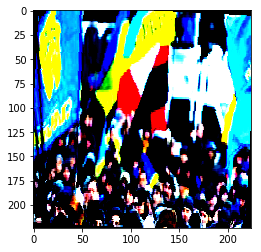

In [12]:
first = next(dummy_test_generator.__iter__())
image = first[0][0]
# protest = first[1][0]
violence = first[1][0]
img = np.array(image)
plt.imshow(img)
# print("protest has shape", protest.shape, " violence has shape", violence.shape)
print("violence has shape", violence.shape)

In [22]:
mask_value = -1; lr = 0.01; momentum = 0.9; epochs = 100; patience = 10

In [23]:
hyper_params_name = "momentum-{}_batch_size-{}_n_folds-{}_n_folds_seed-{}".format(momentum, batch_size, n_folds,seed)
hyper_params_name

'momentum-0.9_batch_size-8_n_folds-5_n_folds_seed-300'

In [28]:
# COMMENT THIS OUT FOR RUN WITH THE WHOLE DATA SET
# size_sample = 34
# validation_df = validation_df[:34]
# test_df = test_df[:34]
# train_df = train_df[:34]
# batch_size = 8
# epochs = 1
# patience = 0

In [30]:
train_generator = au.ResizeSequence(
    train_df,
    batch_size, 
    targets = ['violence'],
    transforms = [
        transforms.randomResizedCrop,
        transforms.randomRotation,
        transforms.randomHorizontalFlip,
        transforms.colorJitter,
        transforms.normalizeMinMax,
        transforms.lighting,
        transforms.normalizeStandardScore
    ]
)
validation_generator = au.ResizeSequence(
    validation_df,
    batch_size, 
    targets = ['violence'],
    transforms = [
        transforms.resize,
        transforms.centerCrop,
        transforms.normalizeMinMax,
        transforms.normalizeStandardScore
    ]
)

test_generator = au.ResizeSequence(
    test_df,
    batch_size, 
    targets = ['violence'],
    transforms = [
        transforms.resize,
        transforms.centerCrop,
        transforms.normalizeMinMax,
        transforms.normalizeStandardScore
    ]
)



# Modeling start
Kbackend.clear_session()

img_input = Klayers.Input(shape=(224,224,3), name='img_input')

resnet_model = Kapplications.ResNet50(include_top=False, weights = 'imagenet') (img_input)

flatten = Klayers.Flatten()(resnet_model)

# protest_out = Klayers.Dense(1, activation='sigmoid', name='protest_out')(flatten)
violence_out = Klayers.Dense(1, activation='sigmoid', name='violence_out')(flatten)

model = Kmodels.Model(inputs= img_input, outputs=violence_out)

optimizer = Koptimizers.SGD(lr=lr, momentum=momentum, nesterov=False)
model.compile(optimizer=optimizer,
          loss=au.buildMaskedLoss(Klosses.mean_squared_error, mask_value),
#           loss_weights={'protest_out': 1., 
#                         'violence_out': 10 }
             )
model.summary()

try:
    __file__ # Apparently, this is not defined in the notebook,
         # but it will be when we start running on the server
         # (So when things gets real)
except NameError:
    __file__ = "test"


name = au.getExperimentName(__file__, len(df), epochs, lr, hyper_params_name)
csv_results = "models_preds/%s.csv" % name
model_checkout_path = "models/%s.hdf5" % name
csv_logger_path = "logs/%s.csv" % name
tensor_board_folder = os.path.join("logs", name)

if not os.path.exists(tensor_board_folder):
    os.makedirs(tensor_board_folder)

if not os.path.exists(tensor_board_folder):
    os.makedirs("logs")

if not os.path.exists(tensor_board_folder):
    os.makedirs("models")

if not os.path.exists(tensor_board_folder):
    os.makedirs("models_preds")

print("Writing model to: \t%s" % model_checkout_path)
print("Writing log to: \t%s\n" % csv_logger_path)



# callbacks
change_lr = Kcallbacks.LearningRateScheduler(
    au.lrUpdateUCLA, 
    verbose = True
)

checkpoint = Kcallbacks.ModelCheckpoint(
    model_checkout_path,
    monitor='val_loss', 
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    period=1
)

earlystop = Kcallbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0, 
    patience=patience,
    verbose=1, 
    mode='auto'
)

tensor_board = Kcallbacks.TensorBoard(
    log_dir=tensor_board_folder,
     histogram_freq=0,
     batch_size=32, 
     write_graph=True,
     write_grads=False, 
     write_images=False, 
     embeddings_freq=0,
     embeddings_layer_names=None,
     embeddings_metadata=None
)

csv_logger = Kcallbacks.CSVLogger(
    csv_logger_path, 
    separator=',', 
    append=False
)

history = model.fit_generator(
    train_generator,
    validation_data= validation_generator,
    epochs=epochs,
    callbacks = [change_lr, checkpoint, tensor_board, csv_logger, earlystop]
)


# Preds

#load the weights from the best model
model.load_weights(model_checkout_path)

preds = model.predict_generator(test_generator, verbose = 1)
# preds_protest = preds[0][:len(test_df)] # avoid getting more than the needed
preds_violence = preds[:len(test_df)] 
print("Violence shape is ", preds_violence.shape)
# Creates a panda data frame with the results

test_fold_results = test_df.copy()
# test_fold_results["pred_protest"] = preds_protest
test_fold_results["pred_violence"] = preds_violence

print("saving results")
test_fold_results.to_csv(csv_results)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_input (InputLayer)       (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Model)             multiple                  23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
violence_out (Dense)         (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________
Writing model to: 	models/test_datalen-40720_epochs-1_init_lr-0.01_momentum-0.9_batch_size-8_n_folds-5_n_folds_seed-300.hdf5
Writing log to: 	logs/test_datalen-40720_epochs-1_init_lr-0.01_momentum-0.9_batch_size-8_n_folds-5_n_folds_seed-300.csv

Epoch 1/1

